# Great Energy Predictor - Preprocessing
#### Hosted by: ASHRAE
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction

## Section I: Dependencies and Data

### Dependencies

In [1]:
# Dependencies
import os
import gc
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import src.utils as udf

%matplotlib inline

In [2]:
# Dataframe settings
pd.set_option('display.max_columns', 50)

# Plot settings
mpl.style.use('seaborn')
mpl.rcParams['figure.figsize'] = (15, 3)
mpl.rcParams['font.size'] = 12

### Data

In [3]:
# Data path
data_path = os.path.join('..', 'data', '01-eda-out')
data_path

'../data/01-eda-out'

In [4]:
# Meter data
meter = pd.read_pickle(os.path.join(data_path, 'meter.pkl'))
meter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20138871 entries, 0 to 20216099
Data columns (total 11 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    uint16        
 1   meter          uint8         
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
 4   site_id        uint8         
 5   meter_type     object        
 6   dayofyear      uint16        
 7   month          uint8         
 8   day            uint8         
 9   dayofweek      uint8         
 10  hour           uint8         
dtypes: datetime64[ns](1), float32(1), object(1), uint16(2), uint8(6)
memory usage: 729.8+ MB


In [5]:
# Weather data
weather = pd.read_pickle(os.path.join(data_path, 'weather.pkl'))
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  uint8         
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float32       
 3   cloud_coverage      70600 non-null   float32       
 4   dew_temperature     139660 non-null  float32       
 5   precip_depth_1_hr   89484 non-null   float32       
 6   sea_level_pressure  129155 non-null  float32       
 7   wind_direction      133505 non-null  float32       
 8   wind_speed          139469 non-null  float32       
dtypes: datetime64[ns](1), float32(7), uint8(1)
memory usage: 4.9 MB


In [6]:
# Building data
building = pd.read_pickle(os.path.join(data_path, 'building.pkl'))
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   uint8  
 1   building_id  1449 non-null   uint16 
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   uint32 
 4   year_built   675 non-null    float32
 5   floor_count  355 non-null    float32
dtypes: float32(2), object(1), uint16(1), uint32(1), uint8(1)
memory usage: 32.7+ KB


In [7]:
# Clean vars
del data_path
gc.collect()

48

## Section II: Meter Preprocessing

### Missing values and zero values in meter data

Aside from the missing meter readings, there are a lot of zero-readings. In the last notebook (`01-eda.ipynb`), we saw that site 0 buildings had readings of 0 for the first 5 months. It is a lot more likely that zero-readings are errors in the data than actually readings of 0, so we will inspect the readings.

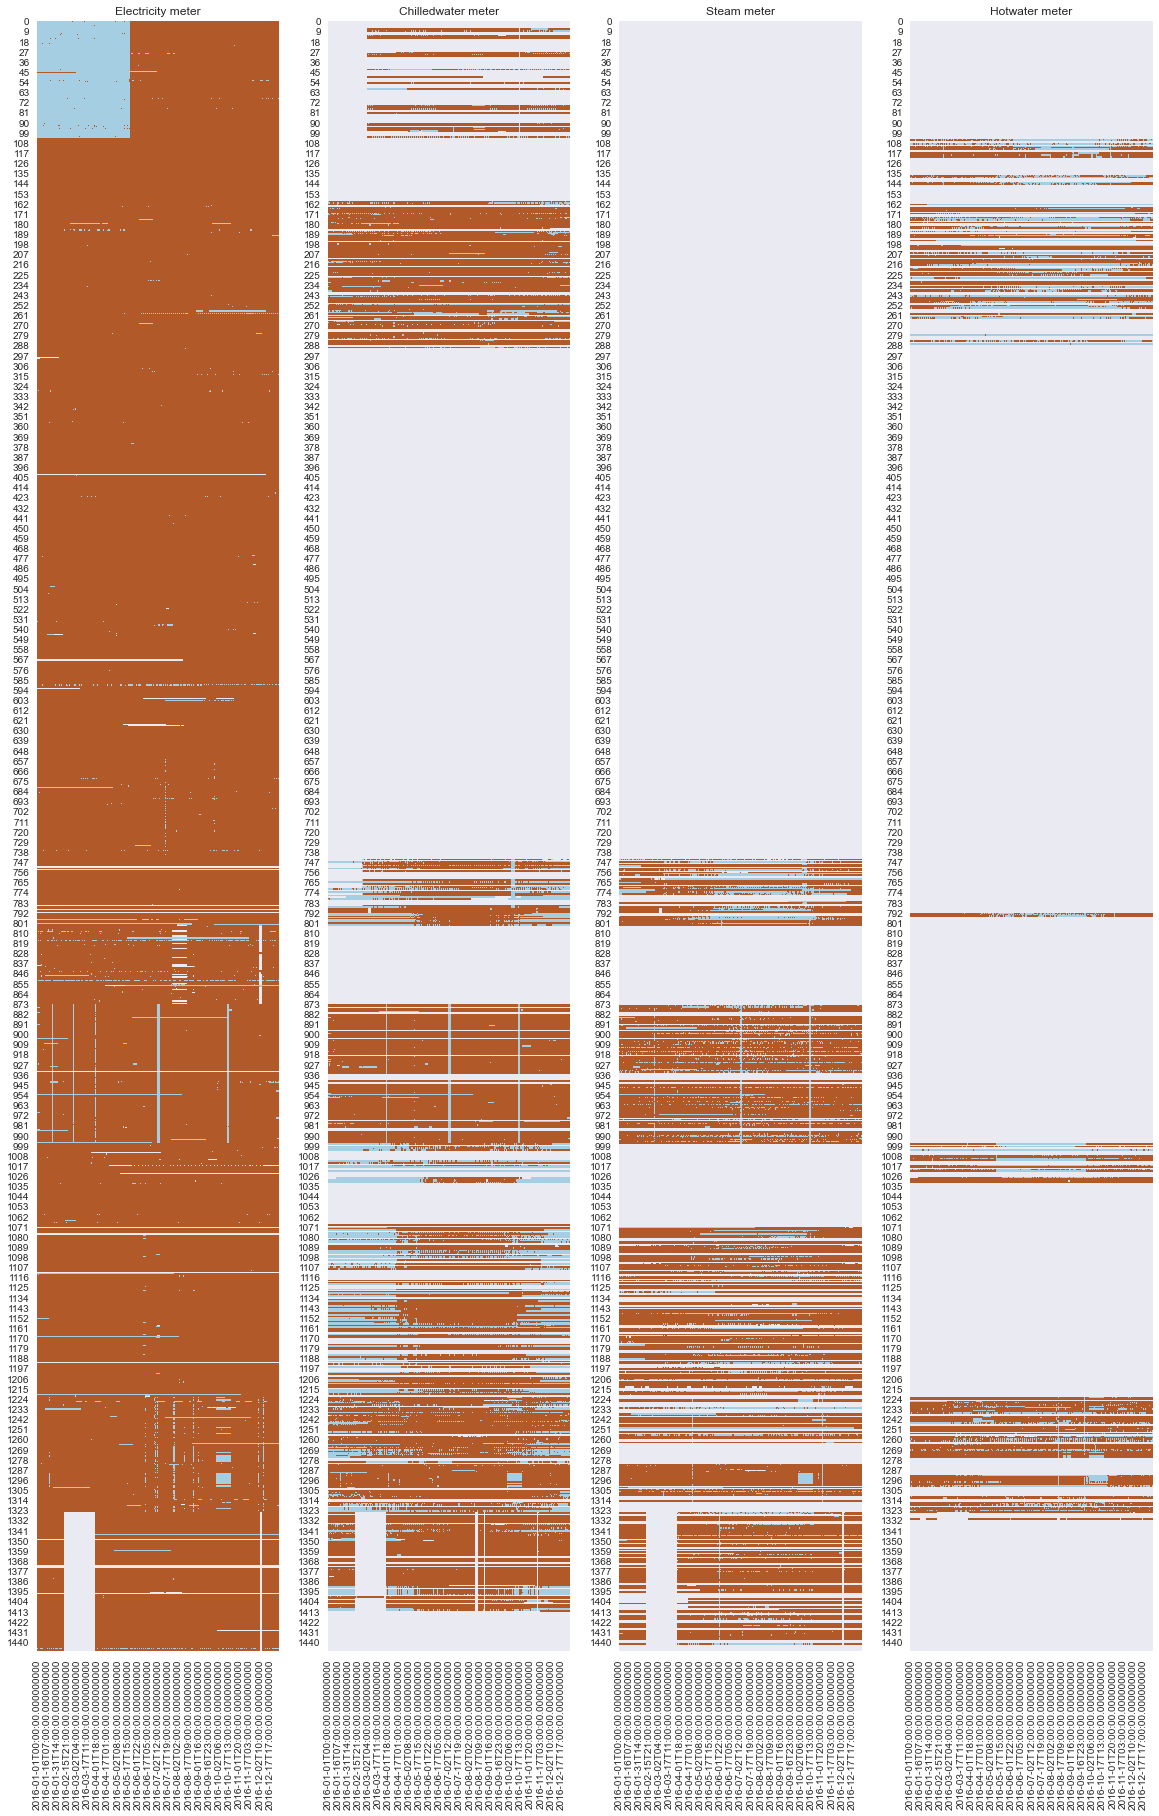

In [8]:
# Visualize missing vals and zeroes
# Adapted from: https://www.kaggle.com/hmendonca/clean-weather-data-eda#Check-the-meter-averages-per-weekday

# Subplots
meter_types = ['electricity', 'chilledwater', 'steam', 'hotwater']
fig, ax = plt.subplots(1, 4, figsize=(20, 30))

# For each meter type
for m in range(4):
    
    # Pivot table of binary vals
    df = meter[meter.meter == m]
    mmap = df.pivot(index='building_id', columns='timestamp', values='meter_reading')
    mmap = mmap.reindex(sorted(meter.building_id.unique()))
    mmap = np.sign(mmap) # convert vals to binary
    
    # Heatmap
    sns.heatmap(mmap, cmap='Paired', ax=ax[m], cbar=False)
    ax[m].set_title(f'{meter_types[m].title()} meter')
    ax[m].set_ylabel(None)
    ax[m].set_xlabel(None)

This code was adapted from a Kaggle user (source in the comment above). For clarity, the plot description is as follows:
- Each of the 4 subplots represents the meter readings from a particular meter type
    - From left to right: `electricity`, `chilledwater`, `steam`, `hotwater`
- Y-axis: building number
- X-axis: 2016 timestamp
- Orange represents non-zero meter readings
- Blue represents zero-readings
- No color represents no readings

Patterns in the meter readings:
- Site 0 buildings are missing readings for both `electricity` and `chilledwater` meters at the beginning of the year
- Site 15 buildings are missing a chunk of readings between February and March for all their meters: `electricity`, `chilledwater`, and `steam`
- A lot of the blue shading come in streaks of long periods of time, so these may actually be missing readings

The most efficient course of action here would be to just remove these zero-readings.

In [9]:
# Drop observations with a meter reading of 0
meter.drop(index=meter.query('meter_reading <= 0').index, inplace=True)
meter.shape

(18264895, 11)

### Buildings built in 2016 and 2017

The data contains buildings with a `year_built` value of 2016 and 2017. This is strange as the meter data contains readings from 2016. It's possible that the readings from these buildings are actually the energy consumption during construction. Either way, these buildings are not aligned with our purpose of predicting energy consumption in normal conditions, so we will inspect these buildings and most likely drop them from our data.

In [10]:
# Inspect buildings built in 2016 and 2017
built_16_17 = building.query('year_built >= 2016')
built_16_17

,site_id,building_id,primary_use,square_feet,year_built,floor_count
28,0,28,Office,52957,2016.0,NaN
45,0,45,Retail,15304,2016.0,NaN
46,0,46,Retail,9045,2016.0,NaN
99,0,99,Office,2260,2016.0,NaN
103,0,103,Education,21657,2016.0,NaN
363,3,363,Education,69300,2017.0,NaN
409,3,409,Education,38500,2016.0,NaN
567,4,567,Entertainment/public assembly,82670,2016.0,4.0


In [11]:
# Count meter readings in these buildings
n_readings_16_17 = meter[meter['building_id'].isin(built_16_17['building_id'])] # filter for 2016/2017 buildings
n_readings_16_17 = n_readings_16_17.groupby('building_id')['meter_reading'].count() # count readings for each building
n_readings_16_17['Total'] = n_readings_16_17.sum() # calculate total
pd.DataFrame(n_readings_16_17).reset_index() # convert to df

,building_id,meter_reading
0,28,11135
1,45,4427
2,46,6862
3,99,5406
4,103,10694
5,363,8782
6,409,8782
7,567,3465
8,Total,59553


There are almost 60 thousand meter readings from buildings built in either 2016 or 2017. That's quite a bit of meter readings, but relatively insignificant when we consider that there are over 18 million readings in the data. We will drop these buildings and their meter readings from the data.

In [12]:
# Remove 2016 and 2017 buildings
meter = meter[~meter['building_id'].isin(built_16_17['building_id'])]
meter.shape

(18205342, 11)

In [13]:
# Clean vars
del meter_types, fig, ax, m, df, mmap, built_16_17, n_readings_16_17
gc.collect()

46496

## Section III: Weather Preprocessing

### Reindex weather data

In the last notebook, we saw that the weather data for 2016 was incomplete, i.e. it did not have a record for every hour of every day in every site (24 hours, 366 days in 2016, 16 sites). In other words, there should be 24 x 366 x 16, or `140,544`, timestamps, but more than 700 were missing. So we will reindex the weather data to include every timestamp.

In [14]:
# Reindex weather data to include every hour of every day in 2016
weather = udf.reidx_site_time(weather, t_start='1/1/2016 00:00:00', t_end='12/31/2016 23:00:00')
weather = udf.reduce_mem_usage(weather)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140544 entries, 0 to 140543
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             140544 non-null  uint8         
 1   timestamp           140544 non-null  datetime64[ns]
 2   air_temperature     139651 non-null  float32       
 3   cloud_coverage      70566 non-null   float32       
 4   dew_temperature     139593 non-null  float32       
 5   precip_depth_1_hr   89435 non-null   float32       
 6   sea_level_pressure  129092 non-null  float32       
 7   wind_direction      133441 non-null  float32       
 8   wind_speed          139402 non-null  float32       
dtypes: datetime64[ns](1), float32(7), uint8(1)
memory usage: 5.0 MB


### Inspect missing values

In [15]:
# Missing vals
missing_weather = pd.DataFrame(zip(weather.isnull().sum(), np.round(weather.isnull().mean() * 100, 2)), 
                               index=weather.columns, columns=['missing', 'pct_missing'])
missing_weather

,missing,pct_missing
site_id,0,0.00
timestamp,0,0.00
air_temperature,893,0.64
cloud_coverage,69978,49.79
dew_temperature,951,0.68
precip_depth_1_hr,51109,36.37
sea_level_pressure,11452,8.15
wind_direction,7103,5.05
wind_speed,1142,0.81


In [16]:
# Missing vals by site
udf.missing_vals_by_site(weather, pct=True)

,timestamp,pct_missing_air_temperature,pct_missing_cloud_coverage,pct_missing_dew_temperature,pct_missing_precip_depth_1_hr,pct_missing_sea_level_pressure,pct_missing_wind_direction,pct_missing_wind_speed
site_id,,,,,,,,
0,8784,0.09,43.65,0.09,0.06,1.02,2.90,0.06
1,8784,0.25,80.64,0.25,100.00,0.83,0.27,0.24
2,8784,0.10,26.88,0.10,0.83,0.59,6.82,0.15
3,8784,0.15,41.53,0.17,0.51,1.90,1.84,0.15
4,8784,0.09,48.25,0.11,15.08,0.92,1.28,0.09
5,8784,0.35,68.98,0.35,100.00,100.00,3.69,0.36
6,8784,0.18,34.11,0.18,0.07,2.05,8.94,0.51
7,8784,1.99,100.00,2.25,91.68,2.08,1.99,1.99
8,8784,0.09,43.65,0.09,0.06,1.02,2.90,0.06


There are a lot of missing `cloud_coverage` and `precip_depth_1_hr` values in the data, with a couple of sites even missing 100% of these values. Filling in this much data may introduce a large bias to the data, so we will be dropping these weather features instead.

All of the other weather features have less than 10% of their values missing, so filling their values wouldn't have as much of an adverse effect.

In [17]:
# Drop cloud coverage and precipitation
weather.drop(['cloud_coverage', 'precip_depth_1_hr'], axis=1, inplace=True)
weather.head(3)

,site_id,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,19.4,19.4,NaN,0.0,0.0
1,0,2016-01-01 01:00:00,21.1,21.1,1019.400024,0.0,0.0
2,0,2016-01-01 02:00:00,21.1,21.1,1018.799988,210.0,1.5


### Interpolate missing data

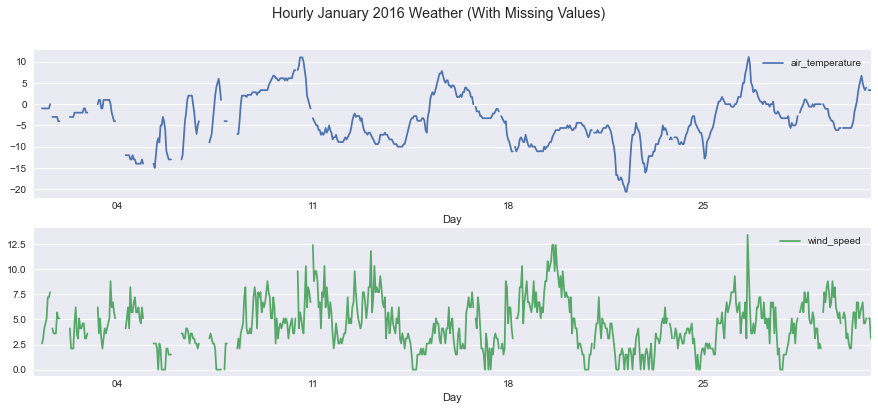

In [18]:
# Time interval to plot
start, end = dt.date(2016, 1, 1), dt.date(2016, 1, 31)

# Site 15 air temp and wind speed
fig, ax = plt.subplots(2, 1, figsize=(15, 6))
w15 = udf.get_site(weather, 15, time_idx=True)
w15.loc[start:end, ['air_temperature', 'wind_speed']].plot(subplots=True, ax=ax, xticks=[], xlabel='Day', 
                                                           title='Hourly January 2016 Weather (With Missing Values)')
plt.show()

In [19]:
# Use linear interpolation for vars with min/max constraints and cubic interpolation for the rest
lin_cols = ['wind_direction', 'wind_speed']
cub_cols = ['air_temperature', 'dew_temperature', 'sea_level_pressure']

# Fill missing vals by site
weather = udf.fill_missing(weather, [], lin_cols, cub_cols)
udf.missing_vals_by_site(weather, pct=True)

,timestamp,pct_missing_air_temperature,pct_missing_dew_temperature,pct_missing_sea_level_pressure,pct_missing_wind_direction,pct_missing_wind_speed
site_id,,,,,,
0,8784,0.0,0.0,0.0,0.0,0.0
1,8784,0.0,0.0,0.0,0.0,0.0
2,8784,0.0,0.0,0.0,0.0,0.0
3,8784,0.0,0.0,0.0,0.0,0.0
4,8784,0.0,0.0,0.0,0.0,0.0
5,8784,0.0,0.0,100.0,0.0,0.0
6,8784,0.0,0.0,0.0,0.0,0.0
7,8784,0.0,0.0,0.0,0.0,0.0
8,8784,0.0,0.0,0.0,0.0,0.0


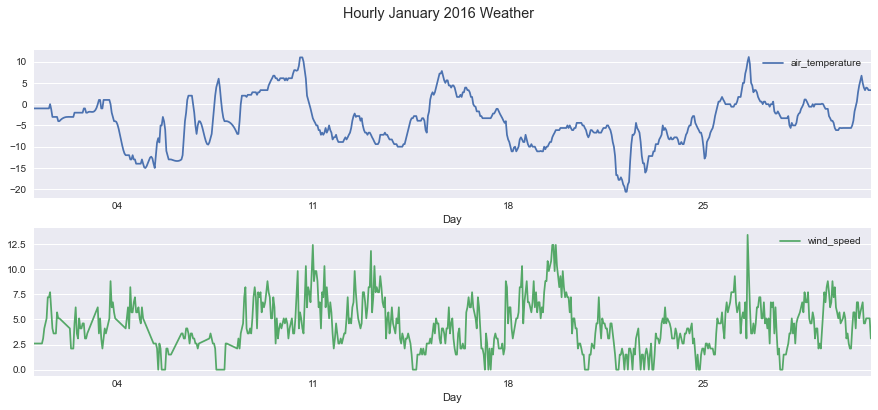

In [20]:
# Site 15 air temp and wind speed
fig, ax = plt.subplots(2, 1, figsize=(15, 6))
w15 = udf.get_site(weather, 15, time_idx=True)
w15.loc[start:end, ['air_temperature', 'wind_speed']].plot(subplots=True, ax=ax, xticks=[], xlabel='Day', 
                                                           title='Hourly January 2016 Weather')
plt.show()

##### Cubic interpolation
I decided to use cubic interpolation because using a polynomial higher than 1 would result in a much smoother estimation of the missing data, as seen in the plot above. Of course, this wasn't possible for every feature due to value constraints, so it was only used for `air_temperature`, `dew_temperature`, and `sea_level_pressure`.

##### Linear interpolation
Since `wind_direction` is limited to values between 0 and 360, and `wind_speed` is limited to non-negative values, linear interpolation was a better choice because it wouldn't result in values outside of these constraints.

##### Forward/backward fill
As interpolation only works for missing values between non-missing values, any leading or trailing missing values (at the beginning or end of the year) was filled using a forward/backward fill.

### Fill missing `sea_level_pressure` values in site 5

The data imputation used above was done on a per-site basis, which means if a site was missing all of its values for a certain feature, this method wouldn't work. While we did manage to fill in most of the missing weather data, site 5 was missing 100% of the `sea_level_pressure` values so these values remain missing.

From the EDA in the last notebook, we discovered that site 5 is in Europe. Because sites 1 and 12 are also in Europe, they may share similar weather to site 5. Without much other context, copying the `sea_level_pressure` from either site 1 or 12 over to site 5 may be our best estimation for the missing values.

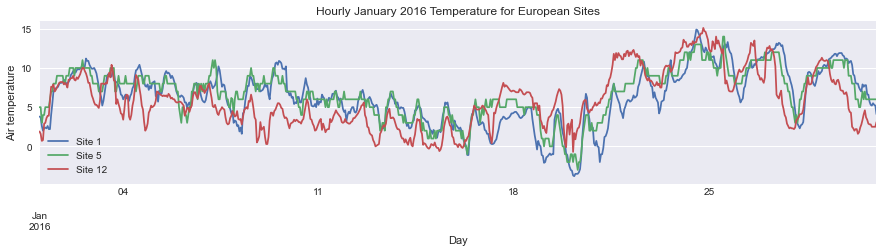

In [21]:
# Extract the 3 European sites
w1 = udf.get_site(weather, 1, time_idx=True)
w5 = udf.get_site(weather, 5, time_idx=True)
w12 = udf.get_site(weather, 12, time_idx=True)

# January air temp from all 3 sites
w1.loc[start:end, 'air_temperature'].plot(label='Site 1')
w5.loc[start:end, 'air_temperature'].plot(label='Site 5')
w12.loc[start:end, 'air_temperature'].plot(label='Site 12')

# Formatting
plt.title('Hourly January 2016 Temperature for European Sites')
plt.ylabel('Air temperature')
plt.xlabel('Day')
plt.legend()
plt.show()

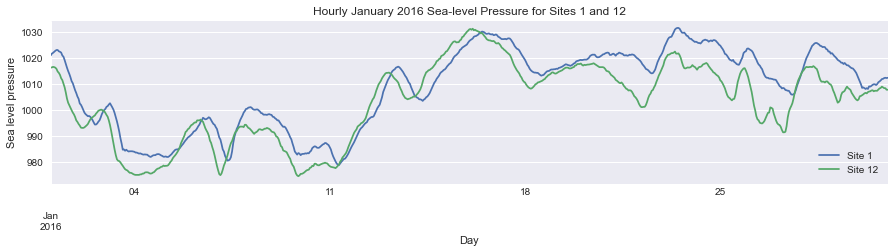

In [22]:
# January sea-level pressure for sites 1 and 12
w1.loc[start:end, 'sea_level_pressure'].plot(label='Site 1')
w12.loc[start:end, 'sea_level_pressure'].plot(label='Site 12')

# Formattinng
plt.title('Hourly January 2016 Sea-level Pressure for Sites 1 and 12')
plt.ylabel('Sea level pressure')
plt.xlabel('Day')
plt.legend()
plt.show()

It looks like the weather of site 5 is more similar to site 1 than site 12, so we will be using the `sea_level_pressure` from site 1 to copy over to site 5.

In [23]:
# Weather indices for sites 1 and 5
i1 = weather[weather.site_id == 1].index 
i5 = weather[weather.site_id == 5].index

# Copy site 1's sea_level_pressure data over to site 5
weather.loc[i5, 'sea_level_pressure'] = weather.loc[i1, 'sea_level_pressure'].values
weather.query('site_id == 5').head(3)

,site_id,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed
43920,5,2016-01-01 00:00:00,5.0,2.0,1020.900024,260.0,2.6
43921,5,2016-01-01 01:00:00,5.0,2.0,1021.599976,260.0,2.6
43922,5,2016-01-01 02:00:00,3.0,1.0,1021.900024,210.0,1.5


In [24]:
# Inspect missing vals again
weather.isnull().sum()

site_id               0
timestamp             0
air_temperature       0
dew_temperature       0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

### Recast wind direction to integer type

In [25]:
# Convert wind_direction to unsigned integers
weather['wind_direction'] = weather['wind_direction'].astype('uint16')
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140544 entries, 0 to 140543
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             140544 non-null  uint8         
 1   timestamp           140544 non-null  datetime64[ns]
 2   air_temperature     140544 non-null  float32       
 3   dew_temperature     140544 non-null  float32       
 4   sea_level_pressure  140544 non-null  float32       
 5   wind_direction      140544 non-null  uint16        
 6   wind_speed          140544 non-null  float32       
dtypes: datetime64[ns](1), float32(4), uint16(1), uint8(1)
memory usage: 3.6 MB


In [26]:
# Clean vars
del missing_weather, start, end, w15, lin_cols, cub_cols, w1, w5, w12, i1, i5, fig, ax
gc.collect()

24802

## Section IV: Building Preprocessing

### Missing values

In [27]:
# Missing vals
missing_building = pd.DataFrame(zip(building.isnull().sum(), round(building.isnull().mean() * 100, 2)), 
                                 index=building.columns, columns=['missing', 'pct_missing'])
missing_building

,missing,pct_missing
site_id,0,0.00
building_id,0,0.00
primary_use,0,0.00
square_feet,0,0.00
year_built,774,53.42
floor_count,1094,75.50


In [28]:
# Check feature correlation
building.corr()

,site_id,building_id,square_feet,year_built,floor_count
site_id,1.000000,0.977283,0.082136,-0.187021,-0.468542
building_id,0.977283,1.000000,0.074312,-0.230185,-0.482477
square_feet,0.082136,0.074312,1.000000,0.109063,0.530298
year_built,-0.187021,-0.230185,0.109063,1.000000,0.099393
floor_count,-0.468542,-0.482477,0.530298,0.099393,1.000000


Even with more than 75% of its values missing, `floor_count` has a moderate linear correlation with `square_feet`. It certainly makes sense, since both of these features are describing the size of the building. We will drop `floor_count` because of the redundancy and since it's missing most of its values anyway.

`Year_built`, on the other hand, does seem to be providing information that the other features are not, so it may be useful to keep this feature. We will be imputing the missing `year_built` values with the median because it's more intuitive to fill a year value with an integer statistic and the median is more robust to outliers than the mean. 

Instead of using the overall median, each building's missing `year_built` value will be imputed with its site's median `year_built`. This would be a better estimation since buildings in the same area are likely to have been built around the same time. But imputing more than half the data means we're guessing on quite a bit of data, so let's first create a boolean missing indicator for `year_built` so that we'll know downstream which values were imputed.

In [29]:
# Drop floor count
building.drop('floor_count', axis=1, inplace=True)

# Add missing indicator for year built
building['missing_year'] = building['year_built'].isnull().astype('uint8')
building.head(3)

,site_id,building_id,primary_use,square_feet,year_built,missing_year
0,0,0,Education,7432,2008.0,0
1,0,1,Education,2720,2004.0,0
2,0,2,Education,5376,1991.0,0


In [30]:
# Num of buildings missing year by site
missing_year_by_site = pd.DataFrame()
missing_year_by_site['n_values'] = building.groupby('site_id')['building_id'].count().values
missing_year_by_site['n_missing'] = building.groupby('site_id')['missing_year'].sum().values
missing_year_by_site['pct_missing'] = (missing_year_by_site['n_missing'] / missing_year_by_site['n_values']).round(4) * 100
missing_year_by_site

,n_values,n_missing,pct_missing
0,105,0,0.00
1,51,11,21.57
2,135,41,30.37
3,274,142,51.82
4,91,2,2.20
5,89,1,1.12
6,44,44,100.00
7,15,1,6.67
8,70,70,100.00
9,124,124,100.00


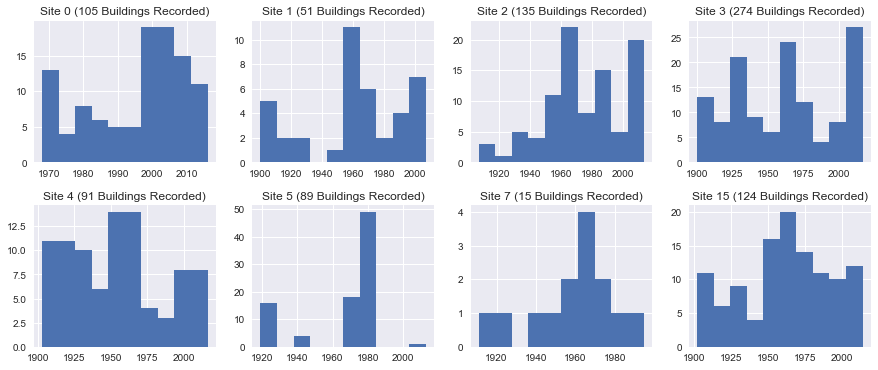

In [31]:
# Sites with at least 1 recorded year built value
sites_with_year_vals = missing_year_by_site[missing_year_by_site.pct_missing < 100].index
i = 0

# Plot these sites
fig, ax = plt.subplots(2, 4, figsize=(15, 6))
fig.subplots_adjust(hspace=0.3)
for a in ax:
    for b in range(4):
        bldg = building[building.site_id == sites_with_year_vals[i]]
        a[b].hist(bldg['year_built'])
        a[b].set_title(f'Site {sites_with_year_vals[i]} ({bldg.shape[0]} Buildings Recorded)')
        i += 1

Half of the sites are missing all of their `year_built` values so the original plan of imputing missing values with site medians won't be able to fill all of the missing data. Let's revise the imputation method for `year_built` a little bit:
1. Impute missing values with the site medians
2. For sites missing 100% of its values, impute the missing values with the median of similar `primary_use` buildings
    - For example, an education building, missing its `year_built` value, will be filled with the median `year_built` of all other education buildings
3. If there are still missing values, impute with the site median again
4. If there are still missing values, impute with the `primary_use` median again

In [32]:
# Fill missing year built vals with the building's site's median year built val
building['year_built'] = building.groupby('site_id')['year_built'].transform(lambda y: y.fillna(y.median()))

# Check pct missing year built again
(missing_year_by_site['n_values'] - building.groupby('site_id')['year_built'].count()) * 100 / \
missing_year_by_site['n_values']

/Users/tribui/miniconda3/envs/minds/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6     100.0
7       0.0
8     100.0
9     100.0
10    100.0
11    100.0
12    100.0
13    100.0
14    100.0
15      0.0
dtype: float64

In [33]:
# Fill the other sites with primary use medians
building['year_built'] = building.groupby('primary_use')['year_built'].transform(lambda y: y.fillna(y.median()))

# Fill the rest with the building's site's median
building['year_built'] = building.groupby('site_id')['year_built'].transform(lambda y: y.fillna(y.median())).astype('uint16')

# Check null count again
building.isnull().sum()

site_id         0
building_id     0
primary_use     0
square_feet     0
year_built      0
missing_year    0
dtype: int64

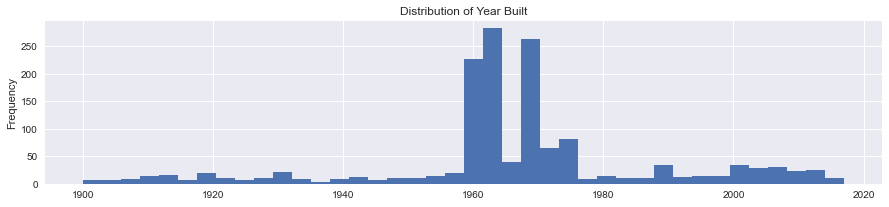

In [34]:
# Distribution of year built values
building['year_built'].plot.hist(bins=40, title='Distribution of Year Built')
plt.show()

In [35]:
# Clean vars
del missing_building, missing_year_by_site, sites_with_year_vals, i, fig, ax, a, b, bldg
gc.collect()

29921

Since we did impute missing values using the median, most of the values will inevitably be concentrated somewhere around the middle as seen in the barchart above. However, we did manage to spread out the imputation a little bit by grouping by site for some and `primary_use` for others. Otherwise, there would be 1 tall bar in the middle, instead of the 3 above.

## Section V: Preprocessing Conclusion

### Save dataframes

In [36]:
# Create new subdir in data dir
output_dir = os.path.join('..', 'data', '02-prep-out')
os.makedirs(output_dir, exist_ok=True)
output_dir

'../data/02-prep-out'

In [37]:
# Save meter data
meter_path = os.path.join(output_dir, 'meter.pkl')
meter.to_pickle(meter_path)
pd.read_pickle(meter_path).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18205342 entries, 72 to 20216099
Data columns (total 11 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    uint16        
 1   meter          uint8         
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
 4   site_id        uint8         
 5   meter_type     object        
 6   dayofyear      uint16        
 7   month          uint8         
 8   day            uint8         
 9   dayofweek      uint8         
 10  hour           uint8         
dtypes: datetime64[ns](1), float32(1), object(1), uint16(2), uint8(6)
memory usage: 659.8+ MB


In [38]:
# Save weather data
weather_path = os.path.join(output_dir, 'weather.pkl')
weather.to_pickle(weather_path)
pd.read_pickle(weather_path).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140544 entries, 0 to 140543
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             140544 non-null  uint8         
 1   timestamp           140544 non-null  datetime64[ns]
 2   air_temperature     140544 non-null  float32       
 3   dew_temperature     140544 non-null  float32       
 4   sea_level_pressure  140544 non-null  float32       
 5   wind_direction      140544 non-null  uint16        
 6   wind_speed          140544 non-null  float32       
dtypes: datetime64[ns](1), float32(4), uint16(1), uint8(1)
memory usage: 3.6 MB


In [39]:
# Save building data
building_path = os.path.join(output_dir, 'building.pkl')
building.to_pickle(building_path)
pd.read_pickle(building_path).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   site_id       1449 non-null   uint8 
 1   building_id   1449 non-null   uint16
 2   primary_use   1449 non-null   object
 3   square_feet   1449 non-null   uint32
 4   year_built    1449 non-null   uint16
 5   missing_year  1449 non-null   uint8 
dtypes: object(1), uint16(2), uint32(1), uint8(2)
memory usage: 25.6+ KB


In [40]:
# Clean vars
del output_dir, meter_path, weather_path, building_path
gc.collect()

22